# Introduction to Long Short-Term Memory (LSTM) Networks
**Authors:** Dr. Rishikesh Yadav / Vedant Vibhor

This notebook builds on the Recurrent Neural Network (RNN) introduction by implementing a Long Short-Term Memory (LSTM) network for time series forecasting using the [UCI Air Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Air+Quality). We predict hourly Carbon Monoxide (CO) concentrations (`CO(GT)`) based on 24 hours of past sensor data. **Learning objectives**:
- Understand LSTMs and their ability to capture long-term dependencies in sequential data
- Preprocess real-world time series data (e.g., handle missing values, create sequences)
- Build, train, and evaluate an LSTM model
- Compare LSTM performance to SimpleRNN and interpret results

**Why LSTMs?** Unlike SimpleRNNs, LSTMs address vanishing gradient issues through memory cells and gates (input, forget, output), allowing them to retain information over longer sequences. This makes them suitable for complex time series like air quality data, where CO levels may depend on patterns from hours or days prior.

## 1. Import Libraries

We use `pandas` for data loading, `numpy` for array operations, `tensorflow` for LSTM modeling, `sklearn` for scaling and metrics, and `matplotlib` for visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Preprocess the UCI Air Quality Dataset

The dataset contains hourly sensor measurements from an Italian city (March 2004–February 2005). We focus on `CO(GT)` (CO concentration in mg/m³), `PT08.S1(CO)` (CO sensor response), `T` (temperature), and `RH` (relative humidity). Missing values are coded as `-200`.

**Steps**:
- Load the dataset
- Handle missing values with forward fill
- Create a datetime index
- Normalize features to [0, 1]

In [ ]:
# Load UCI Air Quality dataset (semicolon-separated, decimal comma)
df = pd.read_csv('../data/AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)

# Drop empty columns and rows with all NaNs
df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Forward-fill missing values (simple imputation for time series)
df.ffill(inplace=True)

# Create datetime index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(['Date', 'Time'], axis=1).set_index('Datetime')

# Select features and target
features = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH']
df = df[features]

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Show first few rows
df.head()

,CO(GT),PT08.S1(CO),T,RH
Datetime,,,,
2004-03-10 18:00:00,2.6,1360.0,13.6,48.9
2004-03-10 19:00:00,2.0,1292.0,13.3,47.7
2004-03-10 20:00:00,2.2,1402.0,11.9,54.0
2004-03-10 21:00:00,2.2,1376.0,11.0,60.0
2004-03-10 22:00:00,1.6,1272.0,11.2,59.6


## 3. Visualize the Data

Plot the first 200 hours of CO(GT) to observe temporal patterns, highlighting the time series nature of the data.

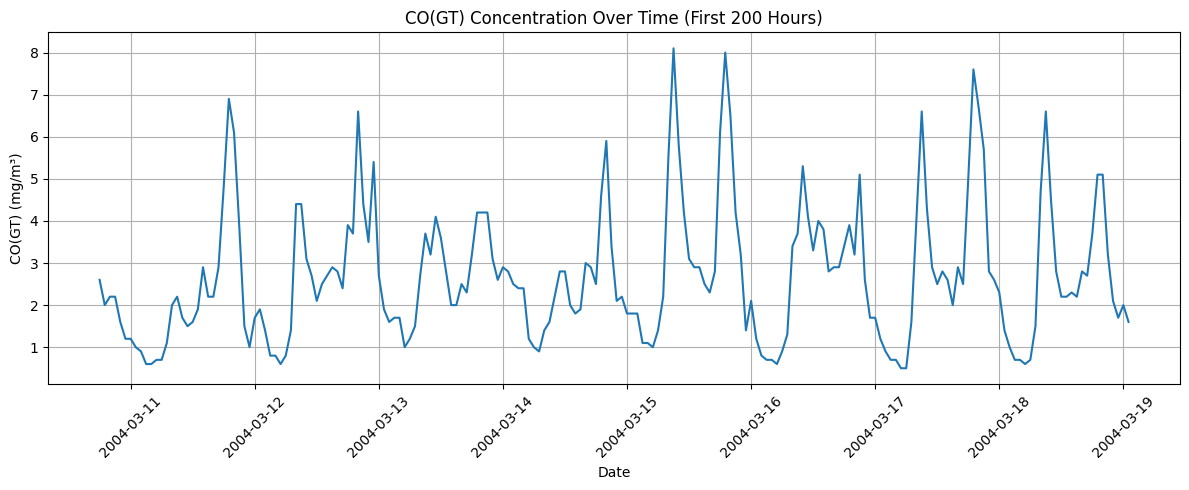

In [3]:
# Plot CO(GT) for first 200 hours
plt.figure(figsize=(12, 5))
plt.plot(df.index[:200], df['CO(GT)'][:200])
plt.title('CO(GT) Concentration Over Time (First 200 Hours)')
plt.xlabel('Date')
plt.ylabel('CO(GT) (mg/m³)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Prepare Data for LSTM

Create sequences of 24 time steps (hours) to predict the next CO(GT) value. Split data into training (80%) and testing (20%) sets.

In [4]:
# Define sequence length
seq_length = 24

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predict CO(GT)
    return np.array(X), np.array(y)

# Create sequences (24 hours = 24 timesteps)
seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

# Split into training and test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


print(f'Training data shape: X={X_train.shape}, y={y_train.shape}')
print(f'Testing data shape: X={X_test.shape}, y={y_test.shape}')

Training data shape: X=(7466, 24, 4), y=(7466,)
Testing data shape: X=(1867, 24, 4), y=(1867,)


## 5. Build the LSTM Model

Construct an LSTM model with two LSTM layers and dropout to prevent overfitting, followed by a dense output layer.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.5),
    LSTM(50),
    Dropout(0.4),
    Dense(1)
], name='CO_Model_LSTM')

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

# Model summary
model.summary()

d:\Mandi\DL Workshop\Into-NNs-main\code\code-NNs\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "CO_Model_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

Train the LSTM model with a validation split to monitor performance.

Epoch 1/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0193 - val_loss: 0.0171
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0098 - val_loss: 0.0157
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0084 - val_loss: 0.0149
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0079 - val_loss: 0.0135
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0076 - val_loss: 0.0130
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0073 - val_loss: 0.0124
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0070 - val_loss: 0.0120
Epoch 8/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0068 - val_loss: 0.0116
Epoch 9/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0065 - val_loss: 0.0110
Epoch 10/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0062 - val_loss: 0.0106
Epoch 11/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0060 - val_loss: 0.0103
Epoch 12/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

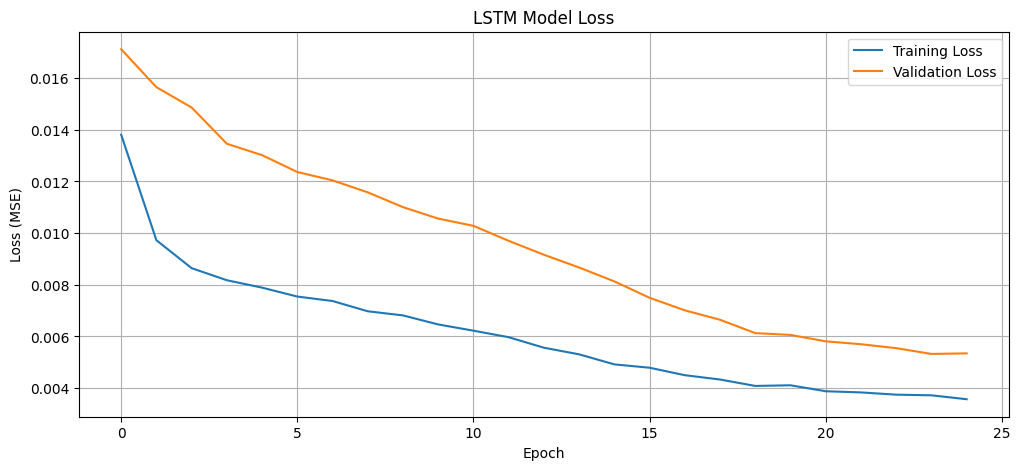

In [6]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.3,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Evaluate and Visualize Predictions

Evaluate the model on the test set using RMSE and plot true vs. predicted CO(GT) values.

Test RMSE: 0.7240 mg/m³


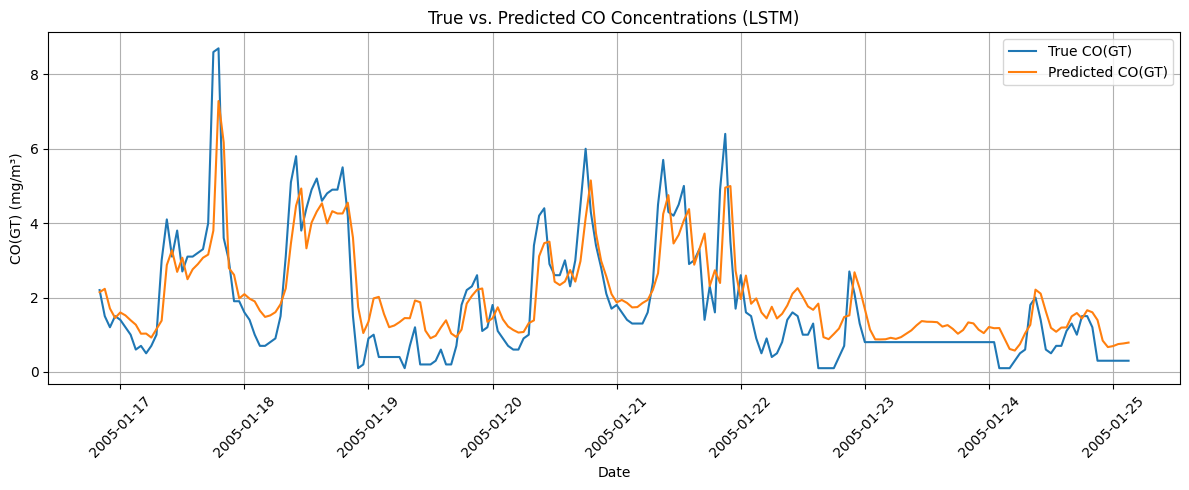

In [7]:
def evaluate_and_plot_predictions(model, X_test, y_test, scaler, dates, max_points=200):
    """
    Evaluate the model and plot true vs. predicted values.

    Args:
        model: Trained Keras model.
        X_test: Test input sequences.
        y_test: True test targets.
        scaler: Fitted MinMaxScaler for inverse transformation.
        dates: Datetime index for test set.
        max_points (int): Number of points to plot.
    """
    # Predict
    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform
    y_test_full = np.zeros((len(y_test), scaler.n_features_in_))
    y_pred_full = np.zeros((len(y_pred), scaler.n_features_in_))
    y_test_full[:, 0] = y_test.flatten()
    y_pred_full[:, 0] = y_pred.flatten()
    y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]
    y_pred_inv = scaler.inverse_transform(y_pred_full)[:, 0]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f'Test RMSE: {rmse:.4f} mg/m³')

    # Plot predictions
    plt.figure(figsize=(12, 5))
    plt.plot(dates[:max_points], y_test_inv[:max_points], label='True CO(GT)')
    plt.plot(dates[:max_points], y_pred_inv[:max_points], label='Predicted CO(GT)')
    plt.title('True vs. Predicted CO Concentrations (LSTM)')
    plt.xlabel('Date')
    plt.ylabel('CO(GT) (mg/m³)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluate and plot
test_dates = df.index[train_size + seq_length:train_size + seq_length + len(y_test)]
evaluate_and_plot_predictions(model, X_test, y_test, scaler, test_dates)

## 8. Debugging Exercise

**Task**: The following code has a bug that causes an error during model training due to incorrect LSTM input configuration. Identify and fix it.

```python
# Buggy code
model_bug = Sequential([
    LSTM(50, input_shape=(len(features), seq_length)),  # Incorrect input shape
    Dense(1)
])
model_bug.compile(optimizer='adam', loss='mse')
model_bug.fit(X_train, y_train, epochs=1)
```

**Hint**: Check the expected input shape for the LSTM layer. What are the dimensions of `X_train`, and how should the `input_shape` be defined?

## 9. Summary and Next Steps

**Key Takeaways**:
- LSTMs improve upon SimpleRNNs by using gates to manage long-term dependencies, making them effective for time series forecasting.
- Proper preprocessing (e.g., forward fill, normalization) ensures robust model training.
- Visualizations and RMSE provide insights into model performance and prediction accuracy.

**Limitations**:
- LSTMs are computationally more expensive than SimpleRNNs.
- The model uses only four features; additional sensors (e.g., NOx, C6H6) may enhance predictions.
- Sequence length and model architecture require tuning for optimal results.

**Next Steps**:
- Experiment with GRU (Gated Recurrent Unit) models for comparison.
- Incorporate more features from the dataset for multivariate forecasting.
- Add attention mechanisms to focus on relevant time steps.
- Apply the LSTM model to other time series datasets (e.g., weather, energy consumption).